1. Imports & Global Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from joblib import dump
from scipy.stats import randint

warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')

2. Data Loading, Time-of-Day Bucketing & Round Assignment

In [2]:
usecols = [
    'Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee',
    'HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
    'B365H','B365D','B365A','B365>2.5','B365<2.5'
]
file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 21-22.csv"
df = pd.read_csv(file_path, usecols=usecols)

df['MatchIndex'] = df.index + 1
df['Round']      = np.ceil(df['MatchIndex'] / 10).astype(int)

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
bins   = [-1, 11, 17, 24]
labels = ['Morning','Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)
df.drop(columns='Hour', inplace=True)

print("Loaded shape:", df.shape)

Loaded shape: (380, 27)


3. Leakage-Free Feature Engineering

In [3]:
# 3.1 Targets
df['Outcome']  = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})
df['Over2.5']  = ((df['FTHG'] + df['FTAG']) >= 3).astype(int)

# 3.2 Implied probabilities from odds
for side in ['H','D','A']:
    df[f'ImpProb_{side}'] = 1.0 / df[f'B365{side}']
prob_cols = ['ImpProb_H','ImpProb_D','ImpProb_A']
df[prob_cols] = df[prob_cols].div(df[prob_cols].sum(axis=1), axis=0)

df['ImpOver2.5']  = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
df[['ImpOver2.5','ImpUnder2.5']] = (
    df[['ImpOver2.5','ImpUnder2.5']]
      .div(df[['ImpOver2.5','ImpUnder2.5']].sum(axis=1), axis=0)
)

# 3.3 Odds spread
df['OddsSpread'] = df['B365H'] - df['B365A']

# 3.4 Rolling 3-match form
df['HomeForm3'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)
df['AwayForm3'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)

# 3.5 Win/Loss streaks
df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: 
          s.eq(1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(1)).cumsum()).cumsum()
      )
)
df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: 
          s.eq(-1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(-1)).cumsum()).cumsum()
      )
)

# 3.6 Interaction
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# 3.7 Referee home-bias
df['RefHomeWins'] = (
    df.groupby('Referee')['Outcome']
      .transform(lambda s: s.eq(1).cumsum().shift(1).fillna(0))
)
df['RefMatches'] = df.groupby('Referee').cumcount()
df['RefBias']    = (df['RefHomeWins'] / df['RefMatches']).fillna(0.5)
df.drop(columns=['RefHomeWins','RefMatches'], inplace=True)

# 3.8 Head-to-head last result
df['PairKey'] = df.apply(
    lambda r: tuple(sorted([r.HomeTeam, r.AwayTeam])), axis=1
)
h2h = {}
def prev_h2h(row):
    key = row.PairKey
    prev = h2h.get(key, 0)
    sign = 1 if row.HomeTeam == key[0] else -1
    h2h[key] = row.Outcome * sign
    return prev

df['H2H_Last'] = df.apply(prev_h2h, axis=1)
df.drop(columns='PairKey', inplace=True)

# 3.9 Rolling averages of match stats
home_stats = ['HS','HST','HF','HC','HY','HR']
away_stats = ['AS','AST','AF','AC','AY','AR']
for stat in home_stats:
    df[f'Home_{stat}_3'] = (
        df.groupby('HomeTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )
for stat in away_stats:
    df[f'Away_{stat}_3'] = (
        df.groupby('AwayTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )

# 3.10 Previous-round table positions
df['HomePts'] = np.where(df['FTR']=='H', 3, np.where(df['FTR']=='D', 1, 0))
df['AwayPts'] = np.where(df['FTR']=='A', 3, np.where(df['FTR']=='D', 1, 0))

pts = pd.DataFrame({
    'Team':  np.concatenate([df['HomeTeam'], df['AwayTeam']]),
    'Round': np.concatenate([df['Round'],    df['Round']]),
    'Pts':   np.concatenate([df['HomePts'],   df['AwayPts']])
})
round_pts = (
    pts
    .groupby(['Team','Round'], as_index=False)['Pts']
    .sum()
)
round_pts['CumPts'] = round_pts.groupby('Team')['Pts'].cumsum()
round_pts['Pos']    = (
    round_pts
    .groupby('Round')['CumPts']
    .rank(method='min', ascending=False)
)
prev = round_pts[['Team','Round','Pos']].copy()
prev.rename(columns={'Round':'PrevRound','Pos':'PrevPos'}, inplace=True)
prev['PrevRound'] += 1

df = df.merge(
    prev, left_on=['HomeTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['HomePosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

df = df.merge(
    prev, left_on=['AwayTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['AwayPosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

4. Pipeline Specification & Hyperparameter Distributions

In [4]:
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint
import numpy as np

# 4.1) safety: ensure feature lists exist (reconstruct if previous cell not run)
if 'cat_feats' not in globals() or 'num_feats' not in globals():
    cat_feats = [c for c in ['HomeTeam','AwayTeam','Referee','TimeOfDay'] if c in df.columns]
    core_num = [
        'HomeForm3','AwayForm3','HomeStreak','AwayStreak',
        'ImpProb_H','ImpProb_D','ImpProb_A',
        'ImpOver2.5','ImpUnder2.5',
        'OddsSpread','Spread×Form','RefBias','H2H_Last',
        'HomePosPrev','AwayPosPrev'
    ]
    core_num = [c for c in core_num if c in df.columns]
    home_stats = ['HS','HST','HF','HC','HY','HR']
    away_stats = ['AS','AST','AF','AC','AY','AR']
    roll_num = [f'Home_{s}_3' for s in home_stats if f'Home_{s}_3' in df.columns] + \
               [f'Away_{s}_3' for s in away_stats if f'Away_{s}_3' in df.columns]
    num_feats = core_num + roll_num

# 4.2) preprocess (categorical: OHE, numeric: MaxAbsScaler → sparse-friendly)
cat_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', min_frequency=2, sparse_output=True))
])

num_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('scale', MaxAbsScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipe, cat_feats),
        ('num', num_pipe, num_feats)
    ],
    sparse_threshold=1.0  # keep sparse matrix for kNN (brute-friendly)
)

# 4.3) kNN pipeline
def make_knn_pipeline():
    return Pipeline(steps=[
        ('prep', preprocessor),
        ('clf', KNeighborsClassifier())
    ])

# 4.4) time-series CV and dynamic RandomizedSearch factory
tscv = TimeSeriesSplit(n_splits=3)
scorers = {'bal_acc': 'balanced_accuracy', 'acc': 'accuracy'}  # compromise: tune on both

def make_rand_search_knn(n_train: int):
    """
    Build a RandomizedSearchCV with a k-range adapted to the current training set size.
    max_k ≈ 2 * sqrt(n_train), capped at 150 and floored at 10.
    """
    max_k = int(min(150, max(10, 2 * np.sqrt(max(1, n_train)))))
    param_distributions = {
        'clf__n_neighbors': randint(3, max_k + 1),   # dynamic upper bound
        'clf__weights': ['uniform', 'distance'],
        'clf__p': [1, 2],                            # Manhattan / Euclidean
        'clf__algorithm': ['auto'],
        'clf__leaf_size': randint(20, 51)
    }
    return RandomizedSearchCV(
        estimator=make_knn_pipeline(),
        param_distributions=param_distributions,
        n_iter=40,               # if slow: set to 20
        cv=tscv,
        scoring=scorers,
        refit='bal_acc',         # select by balanced accuracy (compromise)
        n_jobs=-1,
        random_state=42,
        verbose=0
    )


5. Round-by-Round Training & Prediction with Tuning

In [5]:
from sklearn.metrics import accuracy_score
import numpy as np

# 5.1) containers
preds, actuals, rounds, match_indices = [], [], [], []

# 5.2) warm-up (first 5 rounds; no tuning here)
WARMUP_ROUNDS = 5
WARMUP_MATCHES = WARMUP_ROUNDS * 10

X_warm = df.loc[:WARMUP_MATCHES-1, cat_feats + num_feats]
y_warm = df.loc[:WARMUP_MATCHES-1, 'Outcome']

# simple warm-up fit (preprocessor + kNN), not used for prediction later
_ = make_knn_pipeline().fit(X_warm, y_warm)

# 5.3) predict from round 6 onward (exactly 10 matches/round)
max_round = int(df['Round'].max())
for r in range(WARMUP_ROUNDS + 1, max_round + 1):
    train_mask = df['Round'] < r
    test_mask  = df['Round'] == r

    X_train = df.loc[train_mask, cat_feats + num_feats]
    y_train = df.loc[train_mask, 'Outcome']

    round_df = df.loc[test_mask, :].sort_values(['Round', 'MatchIndex'])
    if len(round_df) > 10:
        round_df = round_df.head(10)
    if len(round_df) < 10:
        print(f"Round {r}: only {len(round_df)} matches available → skipped.")
        continue

    X_test = round_df[cat_feats + num_feats]
    y_test = round_df['Outcome']

    # 5.4) randomized search with dynamic k-range
    rand_search = make_rand_search_knn(n_train=len(X_train))
    rand_search.fit(X_train, y_train)
    model = rand_search.best_estimator_

    # 5.5) predict exactly 10 matches
    y_pred = model.predict(X_test)

    # 5.6) collect & report (accuracy only + best params log)
    preds.extend(np.asarray(y_pred).ravel().tolist())
    actuals.extend(y_test.tolist())
    rounds.extend([r] * len(y_test))  # always 10
    match_indices.extend(round_df['MatchIndex'].tolist())

    acc = accuracy_score(y_test, y_pred)
    best = rand_search.best_params_
    print(
        f"Round {r}: 10 matches | accuracy = {acc:.3f} | "
        f"best k={best.get('clf__n_neighbors')}, "
        f"weights={best.get('clf__weights')}, p={best.get('clf__p')}"
    )

print(f"Predicted rounds {WARMUP_ROUNDS + 1}–{max_round} (10 matches each)")

# 5.7) expose final model and last train round
final_model = model
last_train_round = max_round - 1


Round 6: 10 matches | accuracy = 0.300 | best k=3, weights=distance, p=2
Round 7: 10 matches | accuracy = 0.200 | best k=10, weights=uniform, p=2
Round 8: 10 matches | accuracy = 0.300 | best k=6, weights=uniform, p=1
Round 9: 10 matches | accuracy = 0.600 | best k=5, weights=uniform, p=1
Round 10: 10 matches | accuracy = 0.400 | best k=4, weights=uniform, p=1
Round 11: 10 matches | accuracy = 0.600 | best k=15, weights=uniform, p=1
Round 12: 10 matches | accuracy = 0.300 | best k=17, weights=distance, p=1
Round 13: 10 matches | accuracy = 0.300 | best k=11, weights=uniform, p=2
Round 14: 10 matches | accuracy = 0.600 | best k=12, weights=distance, p=2
Round 15: 10 matches | accuracy = 0.700 | best k=12, weights=distance, p=2
Round 16: 10 matches | accuracy = 0.700 | best k=15, weights=uniform, p=1
Round 17: 10 matches | accuracy = 0.400 | best k=17, weights=uniform, p=2
Round 18: 10 matches | accuracy = 0.400 | best k=19, weights=uniform, p=1
Round 19: 10 matches | accuracy = 0.500 | 

6. Assemble, Save Results & Final Model

In [6]:
# 6.1 Assemble DataFrame of predictions
df_idx = df.set_index('MatchIndex')
homes = [df_idx.loc[i, 'HomeTeam'] for i in match_indices]
aways = [df_idx.loc[i, 'AwayTeam'] for i in match_indices]

results_df = pd.DataFrame({
    'MatchIndex': match_indices,
    'Round':       rounds,
    'HomeTeam':    homes,
    'AwayTeam':    aways,
    'Actual':      actuals,
    'Predicted':   preds
})

label_map = {1: 'H', 0: 'D', -1: 'A'}
results_df['ActualLabel'] = results_df['Actual'].map(label_map)
results_df['PredLabel']   = results_df['Predicted'].map(label_map)

# 6.2 Save predictions to Excel
output_path = r"D:\python\premier league predictor\knn_predictions_vs_actuals.xlsx"
results_df.to_excel(output_path, index=False)
print("Results written to", output_path)

# 6.3 Save final trained pipeline
dump(model, r"D:\python\premier league predictor\knn_pl_pipeline.joblib")
print("Final kNN pipeline saved.")

Results written to D:\python\premier league predictor\knn_predictions_vs_actuals.xlsx
Final kNN pipeline saved.


7. Results & Visualization

C:\Users\markf\AppData\Local\Temp\ipykernel_16144\3957817979.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g['True'], g['Pred']))


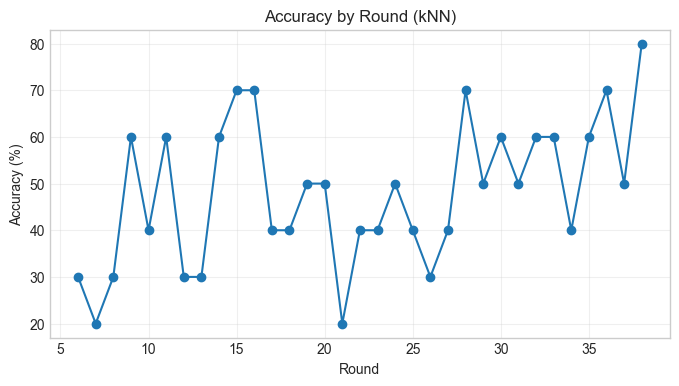

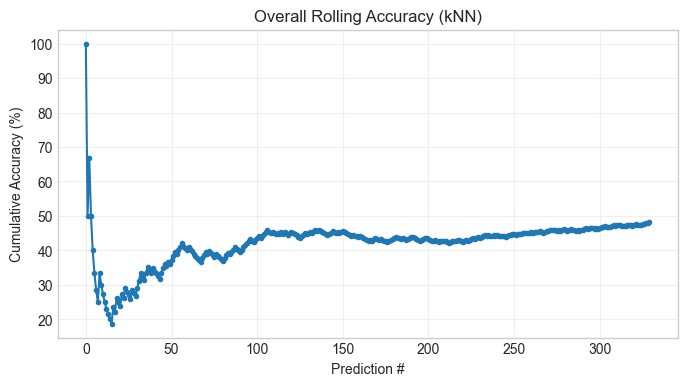

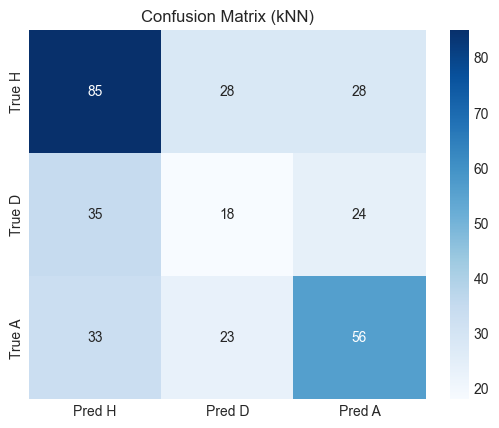


Overall accuracy (rounds 6–38): 0.482
Text summary: The model achieved an overall accuracy of 48.2% across rounds 6–38.


In [7]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# round-by-round accuracy
res = pd.DataFrame({'Round': rounds, 'Pred': preds, 'True': actuals})
round_acc = res.groupby('Round') \
               .apply(lambda g: accuracy_score(g['True'], g['Pred']))

plt.figure(figsize=(8,4))
plt.plot(round_acc.index, round_acc.values * 100, marker='o')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Round (kNN)')
plt.grid(alpha=0.3)
plt.show()

# cumulative accuracy
cum_acc = np.cumsum(np.array(preds) == np.array(actuals)) / np.arange(1, len(preds) + 1)
plt.figure(figsize=(8,4))
plt.plot(cum_acc * 100, marker='.')
plt.xlabel('Prediction #')
plt.ylabel('Cumulative Accuracy (%)')
plt.title('Overall Rolling Accuracy (kNN)')
plt.grid(alpha=0.3)
plt.show()

# confusion matrix
cm = confusion_matrix(actuals, preds, labels=[1,0,-1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred H','Pred D','Pred A'],
            yticklabels=['True H','True D','True A'])
plt.title('Confusion Matrix (kNN)')
plt.show()

# --- Overall accuracy (text) ---
overall_acc = accuracy_score(res['True'], res['Pred'])
print(f"\nOverall accuracy (rounds {int(res['Round'].min())}–{int(res['Round'].max())}): {overall_acc:.3f}")
print(f"Text summary: The model achieved an overall accuracy of {overall_acc*100:.1f}% "
      f"across rounds {int(res['Round'].min())}–{int(res['Round'].max())}.")

8. Gradio Interface

In [8]:
import gradio as gr

# ----------------------------------------------------------------------------
# Precompute the training-set means of the odds-derived features:
# ----------------------------------------------------------------------------
odd_feats = [
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5','OddsSpread'
]
odd_means = df[odd_feats].mean()

# ----------------------------------------------------------------------------
# Gradio dropdown choices:
# ----------------------------------------------------------------------------
teams = sorted(df['HomeTeam'].unique())
refs  = sorted(df['Referee'].unique())
times = ['Morning','Afternoon','Evening']

# ----------------------------------------------------------------------------
# Prediction function
# ----------------------------------------------------------------------------
def predict_outcome(home_team, away_team, referee, time_of_day):
    home = df[df.HomeTeam == home_team].iloc[-1]
    away = df[df.AwayTeam == away_team].iloc[-1]
    ref  = df[df.Referee == referee].iloc[-1]
    
    data = {}
    for feat in odd_feats:
        data[feat] = odd_means[feat]
    
    data['HomeForm3']  = home['HomeForm3']
    data['AwayForm3']  = away['AwayForm3']
    data['HomeStreak'] = home['HomeStreak']
    data['AwayStreak'] = away['AwayStreak']
    data['Spread×Form'] = data['OddsSpread'] * data['HomeForm3']
    data['RefBias']    = ref['RefBias']
    
    pair = ((df.HomeTeam==home_team)&(df.AwayTeam==away_team)) | \
           ((df.HomeTeam==away_team)&(df.AwayTeam==home_team))
    data['H2H_Last']     = df[pair].iloc[-1]['H2H_Last']
    data['HomePosPrev']  = home['HomePosPrev']
    data['AwayPosPrev']  = away['AwayPosPrev']
    
    for s in home_stats:
        data[f'Home_{s}_3'] = home[f'Home_{s}_3']
    for s in away_stats:
        data[f'Away_{s}_3'] = away[f'Away_{s}_3']
    
    data['HomeTeam']  = home_team
    data['AwayTeam']  = away_team
    data['Referee']   = referee
    data['TimeOfDay'] = time_of_day
    
    Xnew  = pd.DataFrame([data])
    probs = final_model.predict_proba(Xnew)[0]
    classes = list(final_model.classes_)
    
    return (
        float(probs[classes.index(1)] * 100),
        float(probs[classes.index(0)] * 100),
        float(probs[classes.index(-1)] * 100)
    )

# ----------------------------------------------------------------------------
# Launch Gradio interface
# ----------------------------------------------------------------------------
iface = gr.Interface(
    fn=predict_outcome,
    inputs=[
        gr.Dropdown(teams, label="Home Team"),
        gr.Dropdown(teams, label="Away Team"),
        gr.Dropdown(refs,  label="Referee"),
        gr.Dropdown(times, label="Time of Day"),
    ],
    outputs=[
        gr.Number(label="Home Win %"),
        gr.Number(label="Draw %"),
        gr.Number(label="Away Win %")
    ],
    title="Premier League Outcome Predictor (kNN)",
    description=(
        "Select Home/Away teams, Referee and Time of Day. "
        "Odds-derived features use historical averages, "
        "other features pulled from past matches."
    )
)

iface.launch()



* Running on local URL:  http://127.0.0.1:7871

To create a public link, set `share=True` in `launch()`.
